In [1]:
import os
import pandas as pd
import sys 
sys.path.append('/home/zhouzikai/nn_ext_dataflows/data_analysis')
from scripts import build_dataframe
import re


BASELINE_DIR = '/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3'
EXTENDED_DIR = '/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3'

def parse_filename_bl(filename):
    pattern = r"([a-z]{2})_([0-9a-zA-Z]+)_baseline_(\d+)_hw_(\d+)_f_(\d+)_nf_(\d+)_s_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        return {
            'anchoring_stationary': match.group(1),
            'num_bits': num_bits,
            'vector_length': int(match.group(3)),
            'input_hw': int(match.group(4)),
            'filter_size': int(match.group(5)),
            'num_filters': int(match.group(6)),
            'stride': int(match.group(7)),
            'cpu_type': match.group(8),
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)

def get_data_size_df_bl(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_bl(filename)
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

def append_dataframe(df1, df2, join_keyword='filename'):
    '''
    add the 'size' column from df1 to df2, assuming their indices are the same (file path)
    '''
    merged_df = df2.join(df1)

    return merged_df



def parse_filename_ex(filename):
    pattern = r"vl(\d+)_([0-9a-zA-Z]+)_stride_(\d+)_fs_(\d+)_([a-z]{2})((?:_[a-zA-Z]+_\d+)+)_hw_(\d+)_nf_(\d+)_(\w+)CPU__stats\.txt"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        # Parsing and sorting auxiliary stationary and stats pairs
        aux_pairs_str = match.group(6)
        aux_pairs = re.findall(r"_([a-zA-Z]+)_(\d+)", aux_pairs_str)
        sorted_aux_pairs = sorted(aux_pairs, key=lambda x: x[0])

        aux_data = {}
        for i, (name, value) in enumerate(sorted_aux_pairs):
            if name not in aux_data:
                aux_data[f'aux_{name}'] = int(value)
            else:
                aux_data[f'aux_{name}_{i + 1}'] = int(value)

        return {
            'vector_length': int(match.group(1)),
            'num_bits': num_bits,
            'stride': int(match.group(3)),
            'filter_size': int(match.group(4)),
            'anchoring_stationary': match.group(5),
            'input_hw': int(match.group(7)),
            'num_filters': int(match.group(8)),
            'cpu_type': match.group(9),
            **aux_data
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}


def get_file_size(file_path):
    return os.path.getsize(file_path)


def get_data_size_df_ex(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_ex(filename)
        # if (get_file_size(f)) == 0:
        #     # print("found one empty")
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

# Read Baseline Directory
df_bl = get_data_size_df_bl(BASELINE_DIR)
bl_file_list=[]
for filename in os.listdir(BASELINE_DIR):
   f = os.path.join(BASELINE_DIR, filename)
   bl_file_list.append(f)
df_bl_files = build_dataframe(bl_file_list)
df_bl= append_dataframe(df_bl,df_bl_files)

# Read Extended Directory
df_ex = get_data_size_df_ex(EXTENDED_DIR)
ex_file_list=[]
for filename in os.listdir(EXTENDED_DIR):
   f = os.path.join(EXTENDED_DIR, filename)
   ex_file_list.append(f)
df_ex_files = build_dataframe(ex_file_list)
df_ex= append_dataframe(df_ex,df_ex_files)

In [2]:
COL_FILTER = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters"]

REF_COLS = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters","system.cpu.dcache.demandMissRate::cpu.data","system.cpu.dcache.demandAvgMissLatency::total","system.cpu.dcache.writebacks::total","system.mem_ctrls.dram.numReads::cpu.data","system.mem_ctrls.dram.numWrites::total"]

df_bl = df_bl[COL_FILTER]
df_bl

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_5_nf_4_s_2_ArmO3CPU__stats.txt,0.001665,6955240.0,7224793.0,128,1,2,5,is,56,4
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004170,21723415.0,21995394.0,128,1,1,4,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_8bt_baseline_128_hw_56_f_5_nf_1_s_1_ArmO3CPU__stats.txt,0.000229,2748505.0,3018055.0,128,8,1,5,is,56,1
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_8bt_baseline_512_hw_112_f_3_nf_4_s_2_ArmO3CPU__stats.txt,NaN,NaN,NaN,512,8,2,3,ws,112,4
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_8bt_baseline_512_hw_56_f_5_nf_1_s_2_ArmO3CPU__stats.txt,NaN,NaN,NaN,512,8,2,5,ws,56,1
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_5_nf_1_s_1_ArmO3CPU__stats.txt,NaN,NaN,NaN,128,1,1,5,ws,112,1
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.000422,4478918.0,4748631.0,128,8,2,3,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_56_f_4_nf_4_s_2_ArmO3CPU__stats.txt,0.000182,2832177.0,3101734.0,128,1,2,4,ws,56,4
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_256_hw_56_f_5_nf_2_s_1_ArmO3CPU__stats.txt,NaN,NaN,NaN,256,8,1,5,os,56,2


In [3]:
df_ex = df_ex[COL_FILTER]
df_ex

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_1_fs_5_os_ws_13_is_0_hw_112_nf_2_ArmO3CPU__stats.txt,0.002110,9320922.0,11229044.0,256,1,1,5,os,112,2
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl512_8bt_stride_2_fs_4_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.025483,10829834.0,13067137.0,512,8,2,4,ws,112,8
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_1_fs_4_is_ws_7_os_6_hw_112_nf_16_ArmO3CPU__stats.txt,0.010693,19591710.0,20408402.0,256,1,1,4,is,112,16
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl128_8bt_stride_1_fs_4_ws_os_0_is_29_hw_56_nf_2_ArmO3CPU__stats.txt,0.000115,2083798.0,2352962.0,128,8,1,4,ws,56,2
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl512_bin_stride_2_fs_4_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.025375,13191263.0,15428721.0,512,1,2,4,ws,112,8
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_2_fs_5_os_ws_13_is_0_hw_56_nf_16_ArmO3CPU__stats.txt,0.000811,6989825.0,8526483.0,256,1,2,5,os,56,16
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl512_bin_stride_1_fs_3_os_ws_4_is_0_hw_112_nf_4_ArmO3CPU__stats.txt,0.004915,13011871.0,17333662.0,512,1,1,3,os,112,4
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_8bt_stride_1_fs_5_os_ws_13_is_0_hw_56_nf_4_ArmO3CPU__stats.txt,0.000569,4301631.0,5391771.0,256,8,1,5,os,56,4
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_2_fs_3_ws_os_13_is_0_hw_56_nf_8_ArmO3CPU__stats.txt,0.000177,2325569.0,2661659.0,256,1,2,3,ws,56,8


In [4]:
df_ex.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"]).min()

simSeconds   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       1           is                      0.000088  \
                                                               os                      0.000070   
                                                               ws                      0.000054   
                                                   2           is                      0.000106   
                                                               os                      0.000090   
...                                                                                         ...   
512           8        2      5           112      8           os                      0.006133   
                                                               ws                      0.039552   
                                                   16          is                      0.018311   
                                                               os                      0.012243   
                                                               ws                      0.079205   

                                                                                       simInsts   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       1           is                     1775356.0  \
                                                               os                     1832004.0   
                                                               ws                     1772460.0   
                                                   2           is                     1884023.0   
                                                               os                     2006379.0   
...                                                                                         ...   
512           8        2      5           112      8           os                    12795177.0   
                                                               ws                    15989968.0   
                                                   16          is                    67427261.0   
                                                               os                    23932938.0   
                                                               ws                    30322425.0   

                                                                                         simOps  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary              
128           1        1      3           56       1           is                     2046179.0  
                                                               os                     2101109.0  
                                                               ws                     2041586.0  
                                                   2           is                     2154854.0  
                                                               os                     2275492.0  
...                                                                                         ...  
512           8        2      5           112      8           os                    21804128.0  
                                                               ws                    19334280.0  
                                                   16          is                    87707777.0  
                                                               os                    41681729.0  
                                                               ws                    36741913.0  

[756 rows x 3 columns]

In [5]:
df_ex = df_ex.rename(columns={"simSeconds":"simSeconds_opt","simInsts":"simInsts_opt","simOps":"simOps_opt"})
df_merged = pd.merge(df_ex,df_bl,how='left',left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"],right_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"])

In [6]:
NUM_FILTER_LOWER = 8
NUM_FILTER_UPPER = 16
VEC_LEN_LIST = [128,256]

In [7]:
df_merged[(df_merged["num_filters"]>= NUM_FILTER_LOWER) &(df_merged["num_filters"]<= NUM_FILTER_UPPER)& (df_merged["vector_length"].isin(VEC_LEN_LIST))]

,simSeconds_opt,simInsts_opt,simOps_opt,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters,simSeconds,simInsts,simOps
2,0.010693,19591710.0,20408402.0,256,1,1,4,is,112,16,0.024180,74529695.0,81623191.0
7,0.008744,22860043.0,28471286.0,256,1,2,5,os,112,16,0.012041,37409940.0,43062995.0
8,0.005174,4121997.0,4620974.0,128,8,2,3,ws,112,16,0.014613,9720602.0,9989763.0
9,0.011610,8545293.0,9943119.0,256,1,1,3,ws,56,16,0.015453,13856674.0,15095369.0
11,0.059005,31710028.0,36953513.0,256,1,1,3,ws,112,16,0.072553,48612506.0,52625206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,0.003683,6822849.0,7106916.0,128,8,1,4,os,112,8,0.006846,37556691.0,37826415.0
1305,0.163186,69193930.0,83801576.0,256,8,1,5,ws,112,16,0.187575,115252007.0,126286768.0
1312,0.021382,10861600.0,11828480.0,128,1,1,3,ws,112,8,0.029970,20457380.0,20726944.0
1323,0.000811,6989825.0,8526483.0,256,1,2,5,os,56,16,NaN,NaN,NaN


<Axes: xlabel='simSeconds'>

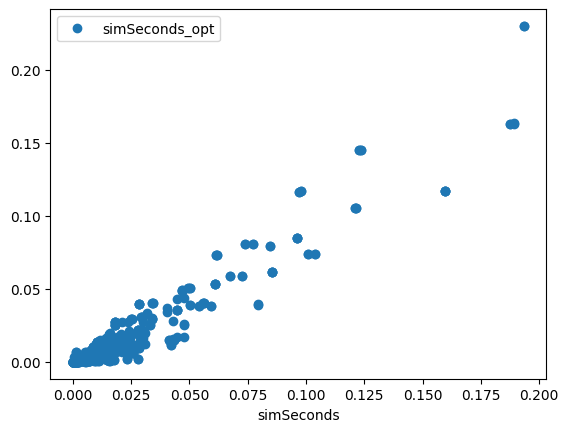

In [8]:
df_merged.plot(x="simSeconds",y="simSeconds_opt",style=['o','rx'])

In [9]:
df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]

(array([ 0.,  0.,  0.,  1.,  3.,  0.,  0.,  4.,  1.,  1.,  3.,  0.,  1.,
         6., 12.,  6., 31., 10., 10., 23.,  8., 14., 33., 16., 14., 21.,
        21., 39., 29., 15., 36., 17., 10., 10., 22., 21., 16., 26., 36.,
        27., 22., 26., 12., 12., 23., 21., 14., 24., 10., 19., 15., 12.,
        11., 17., 12., 14., 11.,  9.,  8.,  7.,  9.,  4.,  6.,  4.,  4.,
         7., 10.,  3.,  4.,  2.,  5.,  6.,  5.,  4.,  3.,  7.,  7.,  2.,
         4.,  2.,  2.,  4.,  2.,  1.,  2.,  0.,  0.,  2.,  3.,  0.,  2.,
         3.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.

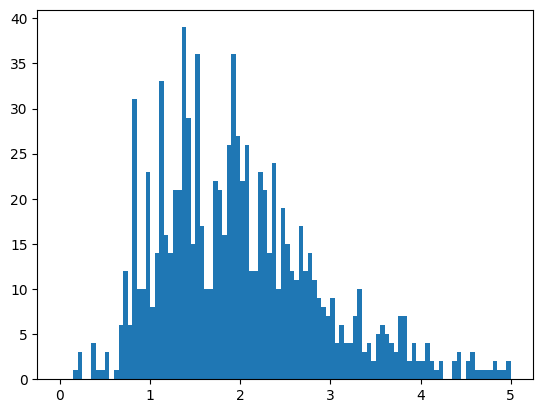

In [10]:
import matplotlib.pyplot as plt

plt.hist(df_merged['improvement'], range=[0, 5],bins=100)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
         4.,  2.,  5.,  1.,  8.,  7.,  4.,  5., 10., 11.,  5.,  9., 12.,
        11., 11., 15.,  7.,  3., 10.,  9.,  8.,  8.,  5.,  8.,  7.,  8.,
         8.,  9.,  3.,  6.,  7.,  4.,  5.,  6.,  4.,  1.,  2.,  2.,  3.,
         2.,  3.,  3.,  2.,  1.,  2.,  3.,  1.,  4.,  2.,  1.,  0.,  0.,
         2.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  1.,
         2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.

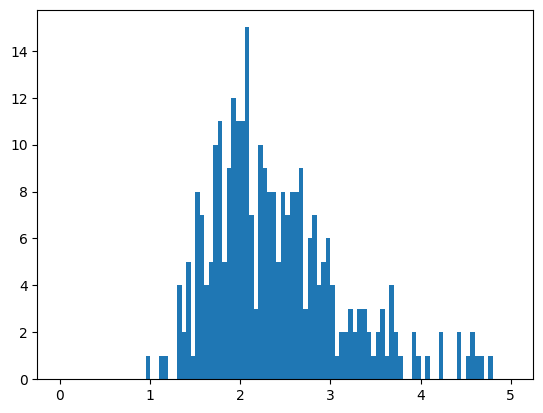

In [11]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='is']['improvement'], range=[0, 5],bins=100)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  7.,  5., 10.,  5.,  6., 10.,  7.,
        10., 16.,  5.,  8., 17.,  9.,  5.,  5., 11.,  9.,  7., 11., 17.,
        10.,  3.,  6.,  1.,  3., 11., 10.,  4., 10.,  2.,  7.,  4.,  2.,
         0.,  4.,  1.,  2.,  1.,  2.,  1.,  0.,  5.,  1.,  2.,  0.,  0.,
         1.,  4.,  0.,  2.,  1.,  2.,  1.,  3.,  0.,  1.,  2.,  4.,  2.,
         1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.

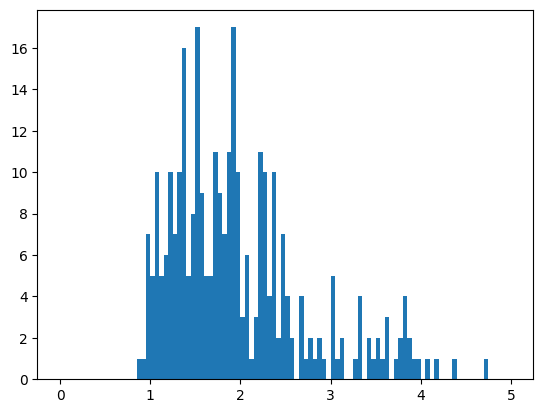

In [12]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='os']['improvement'], range=[0, 5],bins=100)

In [13]:
df_merged['improvement'].mean()

3.1482171216920904

In [14]:
df_merged['improvement'].median()

1.998622651922196

In [15]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==4)]["improvement"].mean()

2.6058780980567056

In [16]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==4)]["improvement"].median()

2.2366058068894468

In [17]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==8)]["improvement"].mean()

2.679258781310865

In [18]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==8)]["improvement"].median()

2.0350712678169542

In [19]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==16)]["improvement"].mean()

2.1130873058302915

In [20]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==16)]["improvement"].median()

1.8603256212510713

In [21]:
df_merged[df_merged["anchoring_stationary"]=="is"]["simSeconds_opt"].mean()

0.003786383838383838

In [22]:
df_merged[df_merged["anchoring_stationary"]=="os"]["simSeconds_opt"].mean()

0.0036127718446601945

In [23]:
df_merged[df_merged["anchoring_stationary"]=="is"]["simSeconds_opt"].median()

0.001619

In [24]:
df_merged[df_merged["anchoring_stationary"]=="os"]["simSeconds_opt"].median()

0.001695

In [25]:
df_ex_is = df_ex[df_ex["anchoring_stationary"]=="is"].drop(columns=["simInsts_opt","simOps_opt","anchoring_stationary"])
df_ex_os = df_ex[df_ex["anchoring_stationary"]=="os"].drop(columns=["simInsts_opt","simOps_opt","anchoring_stationary"])
df_ex_ws = df_ex[df_ex["anchoring_stationary"]=="ws"].drop(columns=["simInsts_opt","simOps_opt","anchoring_stationary"])

In [26]:
df_ex_is = df_ex_is.rename(columns={"simSeconds_opt":"simSecondsIS"})
df_ex_ws = df_ex_ws.rename(columns={"simSeconds_opt":"simSecondsWS"})
df_ex_os = df_ex_os.rename(columns={"simSeconds_opt":"simSecondsOS"})

In [27]:
df_isaws = pd.merge(df_ex_is,df_ex_ws,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_triple = pd.merge(df_isaws,df_ex_os,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [28]:
df_triple = df_triple[(df_triple["num_filters"]>=8) & (df_triple["num_filters"]<=16)]

<Axes: >

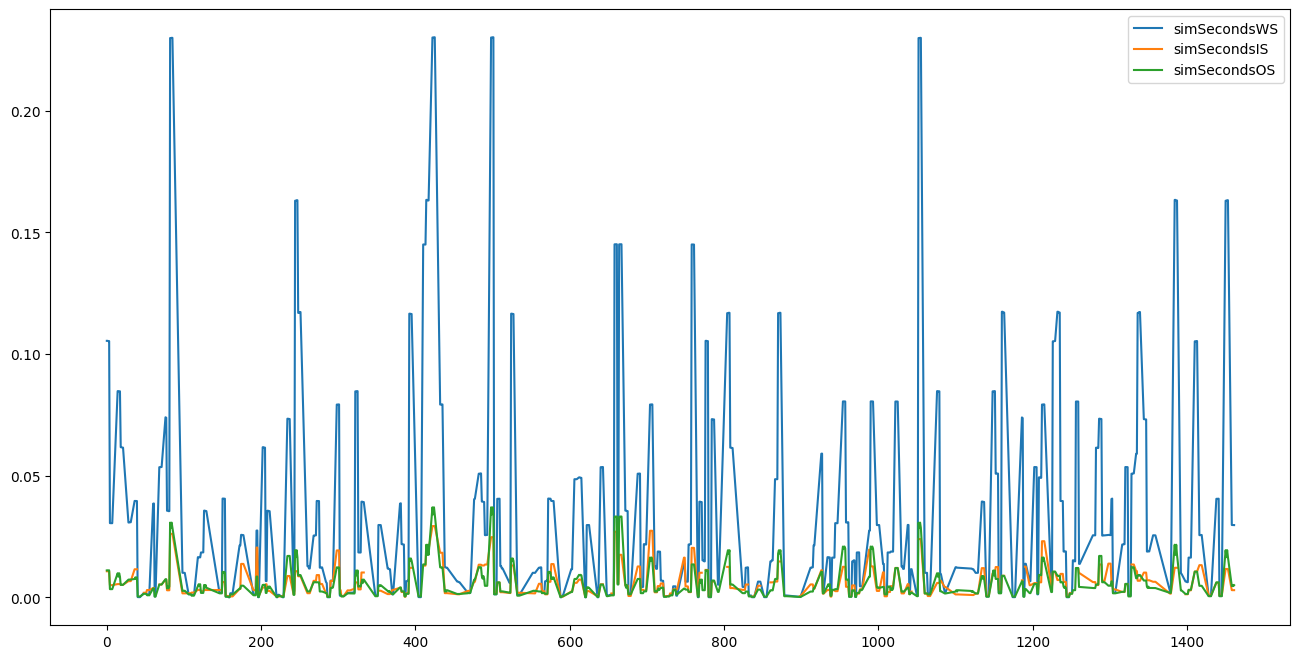

In [29]:
df_triple.plot(y=["simSecondsWS","simSecondsIS","simSecondsOS"],figsize=(16,8))

In [30]:
df_triple["os_vs_is"] = df_triple["simSecondsIS"] - df_triple["simSecondsOS"]

<Axes: >

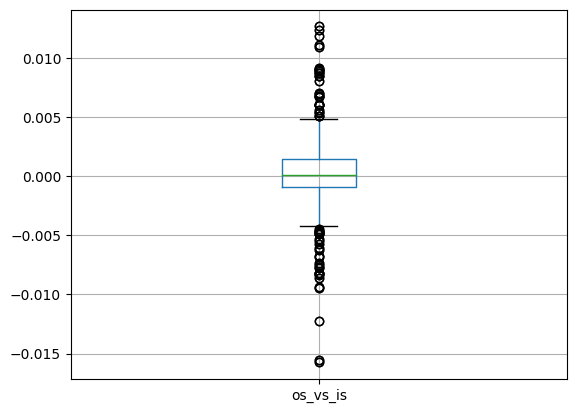

In [31]:
df_triple.boxplot(column="os_vs_is")

In [32]:
len(df_triple[df_triple.os_vs_is > 0])/len(df_triple)

0.5049019607843137